In [2]:
#Following Visium H&E tutorial: from https://squidpy.readthedocs.io/en/stable/tutorials/10-Visium_HE.html

import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import squidpy as sq
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
#importing the spatial data using read_visium 
adata_PA12 = sc.read_visium("spatial_data", load_images=True)
#SPATIAL_DATA CONTAINS PATIENT 12 DATA

# #get the tissue image and the spatial coordinates csv

# coords = pd.read_csv("spatial_data/spatial/tissue_positions_list.csv", header=None, index_col=0)
# coords = coords.loc[adata_PA12.obs_names] #order the coords in the same way as adata object
# # coords.head()
# adata_PA12.obsm["spatial"] = coords

# adata_PA12.obs

# Number 1 thing i learned: scale factors are very important!!

scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.23.5 scipy==1.13.1 pandas==2.3.2 scikit-learn==1.2.2 statsmodels==0.14.5 igraph==0.11.9 louvain==0.8.2 pynndescent==0.5.13
squidpy==1.6.1


/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#standard scanpy clustering and umap workflow
sc.pp.normalize_total(adata_PA12)
sc.pp.log1p(adata_PA12)
sc.pp.pca(adata_PA12)
sc.pp.neighbors(adata_PA12)
sc.tl.umap(adata_PA12)
sc.tl.leiden(adata_PA12)
adata_PA12

/var/folders/lq/975sjw597cx0pdrngj4hf1tr0000gn/T/ipykernel_60182/3340358157.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_PA12)


AnnData object with n_obs × n_vars = 4855 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

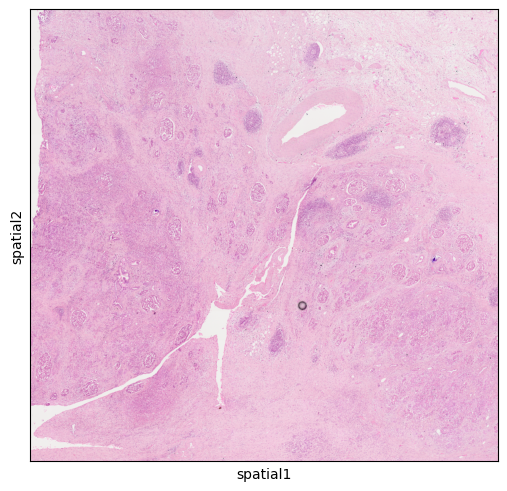

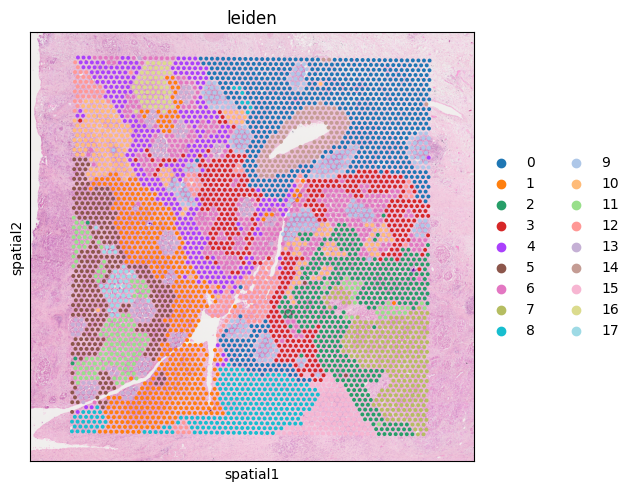

In [4]:
#seeing if it actually worked
sq.pl.spatial_scatter(adata_PA12, size=1)
sq.pl.spatial_scatter(adata_PA12, color="leiden", size=1)

In [5]:
import json
img_path = "spatial_data/spatial/tissue_hires_image.png"
img = sq.im.ImageContainer(img_path)
with open("spatial_data/spatial/scalefactors_json.json") as f:
    sf = json.load(f)
scl = sf["tissue_hires_scalef"]
adata_PA12.obsm["spatial"] = adata_PA12.obsm["spatial"].copy() * scl
#scaling the coordinates to match the highres image

# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata_PA12,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata_PA12.obsm["features"] = pd.concat(
    [adata_PA12.obsm[f] for f in adata_PA12.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata_PA12.obsm["features"].columns = ad.utils.make_index_unique(
    adata_PA12.obsm["features"].columns
)

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: Runtim

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [6]:
adata_PA12.obsm["features"].head()


summary_ch-0_quantile-0.9  summary_ch-0_quantile-0.5  \
AACACCTACTATCGAA-1                      241.0                      235.0   
AACACGTGCATCGCAC-1                      236.0                      230.0   
AACACTTGGCAAGGAA-1                      240.0                      234.0   
AACAGGAAGAGCATAG-1                      236.0                      231.0   
AACAGGATTCATAGTT-1                      239.0                      233.0   

                    summary_ch-0_quantile-0.1  summary_ch-0_mean  \
AACACCTACTATCGAA-1                      219.0         226.401574   
AACACGTGCATCGCAC-1                      212.0         226.505955   
AACACTTGGCAAGGAA-1                      211.0         229.420685   
AACAGGAAGAGCATAG-1                      217.0         228.559026   
AACAGGATTCATAGTT-1                      210.0         228.054158   

                    summary_ch-0_std  summary_ch-1_quantile-0.9  \
AACACCTACTATCGAA-1         38.855313                      209.0   
AACACGTGCATCGCAC-1         11.246661                      206.0   
AACACTTGGCAAGGAA-1         13.860896                      209.0   
AACAGGAAGAGCATAG-1         10.243652                      204.0   
AACAGGATTCATAGTT-1         13.768631                      206.0   

                    summary_ch-1_quantile-0.5  summary_ch-1_quantile-0.1  \
AACACCTACTATCGAA-1                      190.0                      157.0   
AACACGTGCATCGCAC-1                      184.0                      151.0   
AACACTTGGCAAGGAA-1                      188.0                      145.0   
AACAGGAAGAGCATAG-1                      187.0                      162.0   
AACAGGATTCATAGTT-1                      185.0                      146.0   

                    summary_ch-1_mean  summary_ch-1_std  ...  \
AACACCTACTATCGAA-1         182.800480         36.171616  ...   
AACACGTGCATCGCAC-1         181.300413         22.774817  ...   
AACACTTGGCAAGGAA-1         182.700288         27.725306  ...   
AACAGGAAGAGCATAG-1         184.927192         18.702743  ...   
AACAGGATTCATAGTT-1         180.596249         25.344038  ...   

                    summary_ch-1_quantile-0.9-1  summary_ch-1_quantile-0.5-1  \
AACACCTACTATCGAA-1                        205.0                        190.0   
AACACGTGCATCGCAC-1                        202.0                        183.0   
AACACTTGGCAAGGAA-1                        205.0                        187.0   
AACAGGAAGAGCATAG-1                        200.0                        186.0   
AACAGGATTCATAGTT-1                        202.0                        184.0   

                    summary_ch-1_quantile-0.1-1  summary_ch-1_mean-1  \
AACACCTACTATCGAA-1                        160.0           182.343286   
AACACGTGCATCGCAC-1                        155.0           180.831726   
AACACTTGGCAAGGAA-1                        148.0           182.230852   
AACAGGAAGAGCATAG-1                        165.0           184.457790   
AACAGGATTCATAGTT-1                        151.0           180.127421   

                    summary_ch-1_std-1  summary_ch-2_quantile-0.9-1  \
AACACCTACTATCGAA-1           34.471055                        224.0   
AACACGTGCATCGCAC-1           19.057257                        221.0   
AACACTTGGCAAGGAA-1           24.813823                        223.0   
AACAGGAAGAGCATAG-1           15.678892                        220.0   
AACAGGATTCATAGTT-1           21.688276                        221.0   

                    summary_ch-2_quantile-0.5-1  summary_ch-2_quantile-0.1-1  \
AACACCTACTATCGAA-1                        217.0                        206.0   
AACACGTGCATCGCAC-1                        212.0                        200.0   
AACACTTGGCAAGGAA-1                        214.0                        196.0   
AACAGGAAGAGCATAG-1                        213.0                        203.0   
AACAGGATTCATAGTT-1                        213.0                        198.0   

                    summary_ch-2_mean-1  summary_ch-2_std-1  
AACACCTACTATCGAA-1       

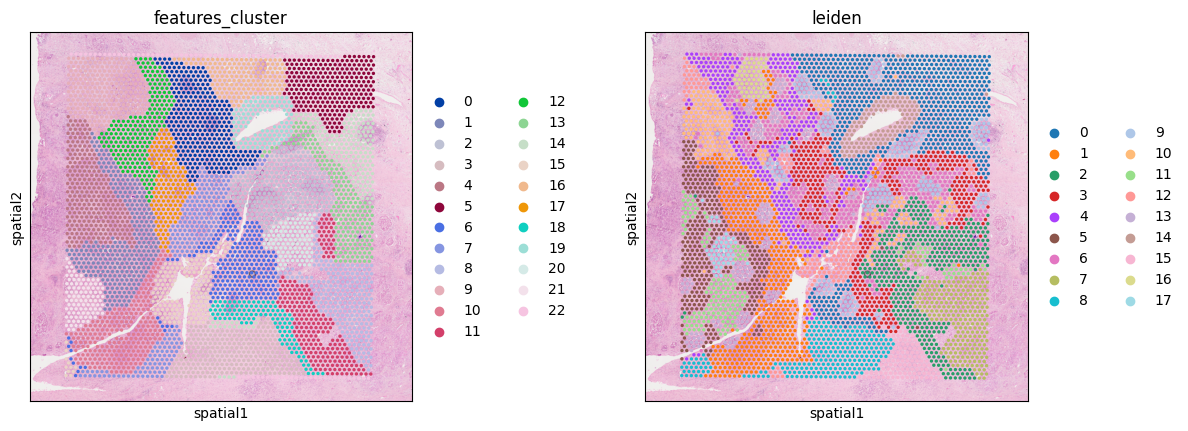

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    #like is a string to filter the features
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(15, features.shape[1] - 1))
    sc.pp.neighbors(adata, n_pcs=15)
    sc.tl.leiden(adata, resolution=0.4)

    return adata.obs["leiden"]

# calculate feature clusters
adata_PA12.obs["features_cluster"] = cluster_features(adata_PA12.obsm["features"], like="summary")

adata_PA12.obsm["spatial"] = adata_PA12.obsm["spatial"].copy() / scl
# divide by scl to get back to original coordinates for plotting

# compare feature and gene clusters
sq.pl.spatial_scatter(adata_PA12, color=["features_cluster", "leiden"], size= 1)

  0%|          | 0/1000 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


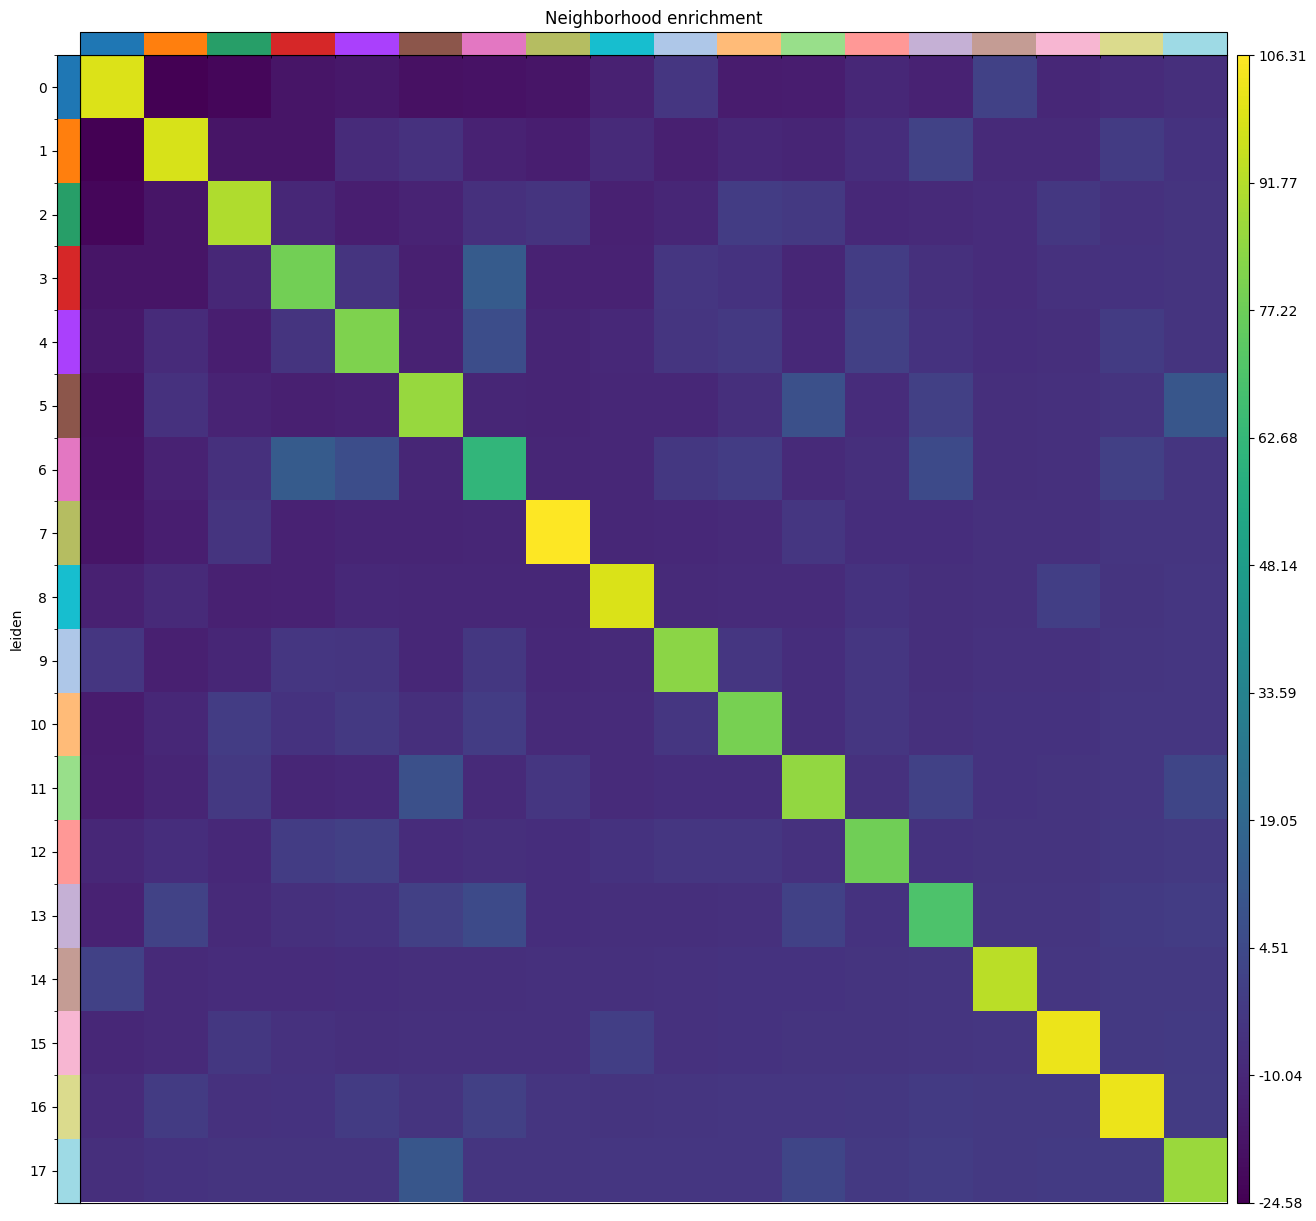

In [8]:
#Neighborhood Enrichment
sq.gr.spatial_neighbors(adata_PA12)
sq.gr.nhood_enrichment(adata_PA12, cluster_key="leiden")
sq.pl.nhood_enrichment(adata_PA12, cluster_key="leiden")

In [9]:
#using SpaGCN for spatial detection (this cell imports the packages)
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#install opencv in python
#!pip3 install opencv-python
import cv2

spg.__version__

'1.2.7'

In [10]:
# Current version of SpaGCN needs:
    # The gene expression matrix(n by k): expression_matrix.h5;
    # Spatial coordinateds of samplespositions.txt;
    # Histology image(optional): histology.tif, can be tif or png or jepg.

spatial = pd.read_csv("spatial_data/spatial/tissue_positions.csv",sep=",",header=0,dtype={1: int, 2: float, 3: float, 4: int, 5: int},index_col=0) 

# spatial.shape
spatial_aligned = spatial.loc[adata_PA12.obs_names]
print(spatial.head)       # shows (n_rows, n_columns)


<bound method NDFrame.head of                     in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
GTCACTTCCTTCTAGA-1          1        0.0        0.0               26406   
CACGGTCTCCTTACGA-1          1        0.0        2.0               26409   
ATAGCTGCGGATAAGA-1          1        0.0        4.0               26412   
GTCAGTATGTCCGGCG-1          1        0.0        6.0               26416   
ATGTACCAGTTACTCG-1          1        0.0        8.0               26419   
...                       ...        ...        ...                 ...   
TCCGACCGCAAGTCCT-1          1       77.0      119.0                1888   
GTCAGTTGGAACCACG-1          1       77.0      121.0                1891   
GTCGAGACCGTCCGTT-1          1       77.0      123.0                1895   
TGGCTGGAGTTATTGT-1          1       77.0      125.0                1898   
AGGATCCGCTCGGTGC-1          1       77.0      127.0                190

In [11]:
adata_PA12.obs["x1"] = spatial_aligned["in_tissue"]
adata_PA12.obs["x2"] = spatial_aligned["array_row"]
adata_PA12.obs["x3"] = spatial_aligned["array_col"]
adata_PA12.obs["x4"] = spatial_aligned["pxl_row_in_fullres"]
adata_PA12.obs["x5"] = spatial_aligned["pxl_col_in_fullres"]
adata_PA12.obs["x_array"] = adata_PA12.obs["x2"]
adata_PA12.obs["y_array"] = adata_PA12.obs["x3"]
adata_PA12.obs["x_pixel"] = (adata_PA12.obs["x4"] * scl).astype(int)
adata_PA12.obs["y_pixel"] = (adata_PA12.obs["x5"] * scl).astype(int)

In [12]:
adata_PA12.obs  # observation level


in_tissue  array_row  array_col leiden features_cluster  \
AACACCTACTATCGAA-1          1          0        122      2               22   
AACACGTGCATCGCAC-1          1         76         22      4                9   
AACACTTGGCAAGGAA-1          1         47         71      4                2   
AACAGGAAGAGCATAG-1          1         69          7     12                9   
AACAGGATTCATAGTT-1          1         49         43     12               17   
...                       ...        ...        ...    ...              ...   
TGTTGGAACGAGGTCA-1          1         28         72      3                6   
TGTTGGAAGCTCGGTA-1          1          1         95     15                3   
TGTTGGATGGACTTCT-1          1         13         53      8               15   
TGTTGGCCAGACCTAC-1          1         49         47      3               17   
TGTTGGCCTACACGTG-1          1         37        127      2               13   

                    x1    x2     x3     x4     x5  x_array  y_array  x_pixel  \
AACACCTACTATCGAA-1   1   0.0  122.0  26601  25292      0.0    122.0     1809   
AACACGTGCATCGCAC-1   1  76.0   22.0   2054   7062     76.0     22.0      139   
AACACTTGGCAAGGAA-1   1  47.0   71.0  11438  16018     47.0     71.0      778   
AACAGGAAGAGCATAG-1   1  69.0    7.0   4276   4276     69.0      7.0      290   
AACAGGATTCATAGTT-1   1  49.0   43.0  10751  10860     49.0     43.0      731   
...                 ..   ...    ...    ...    ...      ...      ...      ...   
TGTTGGAACGAGGTCA-1   1  28.0   72.0  17536  16149     28.0     72.0     1192   
TGTTGGAAGCTCGGTA-1   1   1.0   95.0  26237  20316      1.0     95.0     1784   
TGTTGGATGGACTTCT-1   1  13.0   53.0  22319  12603     13.0     53.0     1518   
TGTTGGCCAGACCTAC-1   1  49.0   47.0  10758  11597     49.0     47.0      731   
TGTTGGCCTACACGTG-1   1  37.0  127.0  14736  26317     37.0    127.0     1002   

                    y_pixel  
AACACCTACTATCGAA-1     1720  
AACACGTGCATCGCAC-1      480  
AACACTTGGCAAGGAA-1     1089  
AACAGGAAGAGCATAG-1      290  
AACAGGATTCATAGTT-1      738  
...                     ...  
TGTTGGAACGAGGTCA-1     1098  
TGTTGGAAGCTCGGTA-1     1381  
TGTTGGATGGACTTCT-1      857  
TGTTGGCCAGACCTAC-1      788  
TGTTGGCCTACACGTG-1     1790  

[4855 rows x 14 columns]

In [13]:
print(spatial.head())

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
GTCACTTCCTTCTAGA-1          1        0.0        0.0               26406   
CACGGTCTCCTTACGA-1          1        0.0        2.0               26409   
ATAGCTGCGGATAAGA-1          1        0.0        4.0               26412   
GTCAGTATGTCCGGCG-1          1        0.0        6.0               26416   
ATGTACCAGTTACTCG-1          1        0.0        8.0               26419   

                    pxl_col_in_fullres  
barcode                                 
GTCACTTCCTTCTAGA-1                2793  
CACGGTCTCCTTACGA-1                3162  
ATAGCTGCGGATAAGA-1                3531  
GTCAGTATGTCCGGCG-1                3900  
ATGTACCAGTTACTCG-1                4269  


In [14]:
img=cv2.imread("spatial_data/spatial/tissue_hires_image.png")
print(img.shape)

#Set coordinates
x_array = adata_PA12.obs["x_array"].tolist()
y_array = adata_PA12.obs["y_array"].tolist()
x_pixel = adata_PA12.obs["x_pixel"].tolist()
y_pixel = adata_PA12.obs["y_pixel"].tolist()

row_pixel = y_pixel
col_pixel = x_pixel


res=10
img_new=img.copy()
for i in range(len(x_pixel)):
	x=x_pixel[i]
	y=y_pixel[i]
	img_new[int(x-res):int(x+res), int(y-res):int(y+res),:]=255

cv2.imwrite('./test_mapping.jpg', img_new)

cv2.imwrite('./test_mapping.jpg', img_new)

#Calculate adjacent matrix

s=1
b=49
adj = spg.calculate_adj_matrix(
    x=row_pixel, y=col_pixel,
    x_pixel=row_pixel, y_pixel=col_pixel,
    image=img, beta=b, alpha=s, histology=True
)

# adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('adj.csv', adj, delimiter=',')

(1932, 2000, 3)
Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  38.9536603093782 185.59148857231807 28.052382094847825
Var of x,y,z =  217478.87820219956 242424.94311325028 242424.9431132503


In [15]:
spg.prefilter_genes(adata_PA12,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata_PA12)
#Normalize and take log for UMI - I already did this in the squidpy workflow
# sc.pp.normalize_per_cell(adata_PA12)
# sc.pp.log1p(adata_PA12)

In [16]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

""" 
    p: Percentage of total expression contributed by neighborhoods.
    l: Parameter to control p.
"""

Run 1: l [0.01, 1000], p [0.0, 2735.120428769201]
Run 2: l [0.01, 500.005], p [0.0, 1050.5899658203125]
Run 3: l [0.01, 250.0075], p [0.0, 267.04473876953125]
Run 4: l [0.01, 125.00874999999999], p [0.0, 56.687255859375]
Run 5: l [0.01, 62.509375], p [0.0, 10.768293380737305]
Run 6: l [0.01, 31.2596875], p [0.0, 1.8665034770965576]
Run 7: l [15.63484375, 31.2596875], p [0.21787559986114502, 1.8665034770965576]
Run 8: l [15.63484375, 23.447265625], p [0.21787559986114502, 0.8397015333175659]
Run 9: l [19.5410546875, 23.447265625], p [0.47975754737854004, 0.8397015333175659]
Run 10: l [19.5410546875, 21.49416015625], p [0.47975754737854004, 0.6473764181137085]
Run 11: l [19.5410546875, 20.517607421875], p [0.47975754737854004, 0.5605008602142334]
Run 12: l [19.5410546875, 20.0293310546875], p [0.47975754737854004, 0.5193647146224976]
recommended l =  19.78519287109375


' \n    p: Percentage of total expression contributed by neighborhoods.\n    l: Parameter to control p.\n'

In [17]:
""" 
    n_clusters: Number of spatial domains wanted.
    res: Resolution in the initial Louvain's Clustering methods. If the number of clusters is known, we can use the spg.search_res() fnction to search for suitable resolution(optional).
"""

n_clusters=22
#Set seed = to ensure the data does the same clustering every time
r_seed=t_seed=n_seed=100

#Search for suitable resolution
res=spg.search_res(adata_PA12, 
                   adj, l, 
                   n_clusters, 
                   start=0.7, 
                   step=0.1, 
                   tol=5e-3, 
                   lr=0.05, 
                   max_epochs=20, 
                   r_seed=r_seed, 
                   t_seed=t_seed, 
                   n_seed=n_seed)



Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  15
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  15
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  16
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  17
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  19
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  19
Res changed to 1.2
Initializing cl

In [18]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata_PA12,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata_PA12.obs["pred"]= y_pred
adata_PA12.obs["pred"]= adata_PA12.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata_PA12.obs.index.tolist(), pred=adata_PA12.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata_PA12.obs["refined_pred"]=refined_pred
adata_PA12.obs["refined_pred"]=adata_PA12.obs["refined_pred"].astype('category')

Initializing cluster centers with louvain, resolution =  1.375
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.004531410916580845 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 34
Calculateing adj matrix using xy only...


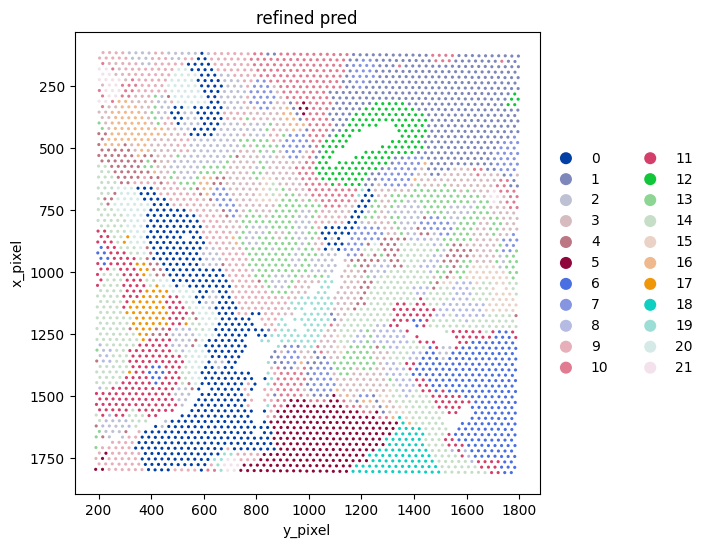

In [19]:
# Plot refined domains

# Create a square figure and axes
fig, ax = plt.subplots(figsize=(6,6))

# Plot on this axes
sc.pl.scatter(
    adata_PA12,
    x="y_pixel",
    y="x_pixel",
    color="refined_pred",
    alpha=1,
    size=100000/adata_PA12.shape[0],
    show=False,
    ax=ax
)

ax.invert_yaxis()  # optional: match image coordinates

In [20]:
#Read in original data (filtered feature bc matrix) to identify SVGs

filtered = sc.read_10x_h5("spatial_data/filtered_feature_bc_matrix.h5")
filtered.var_names_make_unique()

filtered.obs["pred"] = adata_PA12.obs["pred"].astype('category')
filtered.obs["x_array"] = adata_PA12.obs["x_array"]
filtered.obs["y_array"] = adata_PA12.obs["y_array"]
filtered.obs["x_pixel"] = adata_PA12.obs["x_pixel"]
filtered.obs["y_pixel"] = adata_PA12.obs["y_pixel"]

from scipy.sparse import issparse
filtered.X = filtered.X.A if issparse(filtered.X) else filtered.X

sc.pp.log1p(filtered)


In [21]:
#Use domain 0 as an example - this code is taken from the spaGCN tutorial, as an example
target=0

#Set filtering criteria
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5

#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
r=spg.search_radius(target_cluster=target, cell_id=adata_PA12.obs.index.tolist(), x=x_array, y=y_array, pred=adata_PA12.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)

#Detect neighboring domains
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id = filtered.obs.index.tolist(), 
                                   x = filtered.obs["x_array"].tolist(), 
                                   y = filtered.obs["y_array"].tolist(), 
                                   pred = filtered.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)

nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata = filtered,
                                target_cluster=target,
                                nbr_list=nbr_domians, 
                                label_col="pred", 
                                adj_nbr=True, 
                                log=True)

#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [2.0, 19.697715759277344], num_nbr [8.693203883495146, 504.7378640776699]
Calculateing adj matrix using xy only...
Run 2: radius [2.0, 10.848857879638672], num_nbr [8.693203883495146, 164.31844660194176]
Calculateing adj matrix using xy only...
Run 3: radius [2.0, 6.424428939819336], num_nbr [8.693203883495146, 63.93009708737864]
Calculateing adj matrix using xy only...
Run 4: radius [2.0, 4.212214469909668], num_nbr [8.693203883495146, 23.76504854368932]
Calculateing adj matrix using xy only...
recommended radius =  3.106107234954834 num_nbr=12.467961165048544
radius= 3.106107234954834 average number of neighbors for each spot is 12.467961165048544
 Cluster 0 has neighbors:
Dmain  9 :  429
Dmain  2 :  322
Dmain  20 :  249
Dmain  19 :  54
SVGs for domain  0 : []


In [22]:
filtered_info

Empty DataFrame
Columns: [genes, in_group_fraction, out_group_fraction, in_out_group_ratio, in_group_mean_exp, out_group_mean_exp, fold_change, pvals_adj, target_dmain, neighbors]
Index: []

In [23]:
#Plot refinedspatial domains
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
for g in filtered_info["genes"].tolist():
    filtered.obs["exp"]=filtered.X[:,filtered.var.index==g]
    ax=sc.pl.scatter(filtered,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=g,color_map=color_self,show=False,size=100000/filtered.shape[0])
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
    plt.show()

In [33]:
adata_PA12.obs

in_tissue  array_row  array_col leiden features_cluster  \
AACACCTACTATCGAA-1          1          0        122      2               22   
AACACGTGCATCGCAC-1          1         76         22      4                9   
AACACTTGGCAAGGAA-1          1         47         71      4                2   
AACAGGAAGAGCATAG-1          1         69          7     12                9   
AACAGGATTCATAGTT-1          1         49         43     12               17   
...                       ...        ...        ...    ...              ...   
TGTTGGAACGAGGTCA-1          1         28         72      3                6   
TGTTGGAAGCTCGGTA-1          1          1         95     15                3   
TGTTGGATGGACTTCT-1          1         13         53      8               15   
TGTTGGCCAGACCTAC-1          1         49         47      3               17   
TGTTGGCCTACACGTG-1          1         37        127      2               13   

                    x1    x2     x3     x4     x5  x_array  y_array  x_pixel  \
AACACCTACTATCGAA-1   1   0.0  122.0  26601  25292      0.0    122.0     1809   
AACACGTGCATCGCAC-1   1  76.0   22.0   2054   7062     76.0     22.0      139   
AACACTTGGCAAGGAA-1   1  47.0   71.0  11438  16018     47.0     71.0      778   
AACAGGAAGAGCATAG-1   1  69.0    7.0   4276   4276     69.0      7.0      290   
AACAGGATTCATAGTT-1   1  49.0   43.0  10751  10860     49.0     43.0      731   
...                 ..   ...    ...    ...    ...      ...      ...      ...   
TGTTGGAACGAGGTCA-1   1  28.0   72.0  17536  16149     28.0     72.0     1192   
TGTTGGAAGCTCGGTA-1   1   1.0   95.0  26237  20316      1.0     95.0     1784   
TGTTGGATGGACTTCT-1   1  13.0   53.0  22319  12603     13.0     53.0     1518   
TGTTGGCCAGACCTAC-1   1  49.0   47.0  10758  11597     49.0     47.0      731   
TGTTGGCCTACACGTG-1   1  37.0  127.0  14736  26317     37.0    127.0     1002   

                    y_pixel pred refined_pred  TLS_t  TLS_t_PBMC  
AACACCTACTATCGAA-1     1720   11           11  False       False  
AACACGTGCATCGCAC-1      480    2            2  False       False  
AACACTTGGCAAGGAA-1     1089    3            3  False       False  
AACAGGAAGAGCATAG-1      290   10           10  False       False  
AACAGGATTCATAGTT-1      738    3            3  False       False  
...                     ...  ...          ...    ...         ...  
TGTTGGAACGAGGTCA-1     1098    1            1  False       False  
TGTTGGAAGCTCGGTA-1     1381   18           18  False       False  
TGTTGGATGGACTTCT-1      857    9            9  False       False  
TGTTGGCCAGACCTAC-1      788    3            3  False       False  
TGTTGGCCTACACGTG-1     1790   13           13  False       False  

[4855 rows x 18 columns]

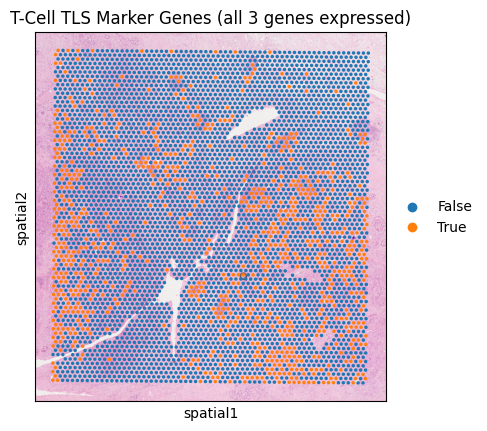

In [57]:
#barcodes for patient 12 tumor cells that are expressing TLS related genes

adata_PA12.var_names_make_unique()

tls_genes = ["CCL5", "CMTM3", "CKLF"] 

# Check which of these genes actually exist in this AnnData object
present_genes = [g for g in tls_genes if g in adata_PA12.var_names]

# Create a boolean column: True if a cell expresses ANY of the TLS genes
adata_PA12.obs["TLS_t"] = (adata_PA12[:, present_genes].X.toarray() > 0).all(axis=1)

# Then plot
sc.pl.spatial(adata_PA12, color="TLS_t", title="T-Cell TLS Marker Genes (all 3 genes expressed)")



Genes found: ['CXCR5', 'CXCL13', 'TNFSF13B']


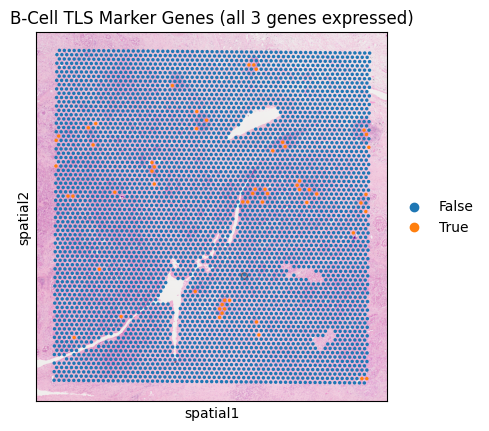

In [58]:
tls_genes_b = ["CXCR5", "CXCL13", "TNFSF13B"]

# Check which of these genes actually exist in this AnnData object
present_genes_b = [g for g in tls_genes_b if g in adata_PA12.var_names]
print("Genes found:", present_genes_b)

# True if a cell expresses all of the TLS genes
adata_PA12.obs["TLS_b"] = (adata_PA12[:, present_genes_b].X.toarray() > 0).all(axis=1)

sc.pl.spatial(adata_PA12, color="TLS_b", title="B-Cell TLS Marker Genes (all 3 genes expressed)")

Genes found: ['IL23A', 'CXCL13', 'CCL19']


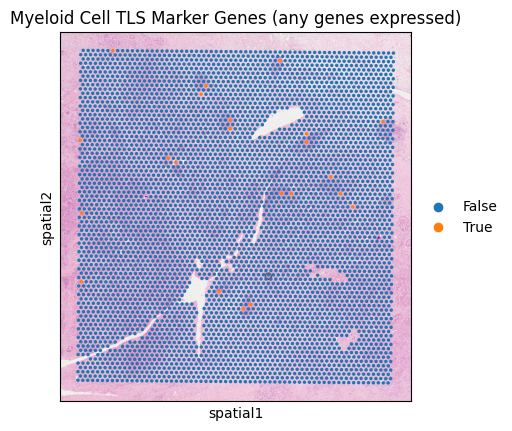

In [60]:
tls_genes_m = ["IL23A", "CXCL13", "CCL19"]

present_genes_m = [g for g in tls_genes_m if g in adata_PA12.var_names]
print("Genes found:", present_genes_m)

adata_PA12.obs["TLS_m"] = (adata_PA12[:, present_genes_m].X.toarray() > 0).all(axis=1)

sc.pl.spatial(adata_PA12, color="TLS_m", title="Myeloid Cell TLS Marker Genes (any genes expressed)")

Genes found: ['SOX10', 'S100B', 'MPZ']


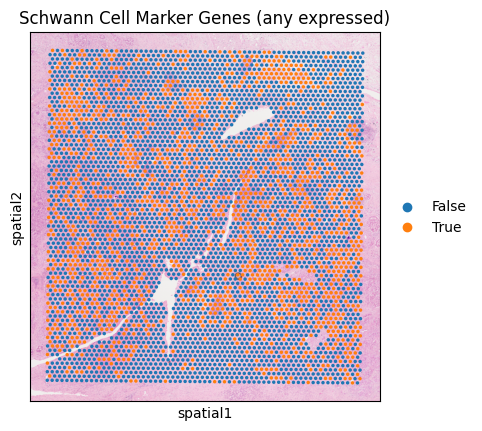

In [67]:
# Locating Schwann cell spots
schwann_genes = ["SOX10", "S100B", "MPZ"]

# Check which of these genes actually exist in this AnnData object
schwann_g = [g for g in schwann_genes if g in adata_PA12.var_names]
print("Genes found:", schwann_g)

# True if a cell expresses all of the TLS genes
adata_PA12.obs["Schwann_Markers"] = (adata_PA12[:, schwann_g].X.toarray() > 0).any(axis=1)

sc.pl.spatial(adata_PA12, color="Schwann_Markers", title="Schwann Cell Marker Genes (any expressed)")

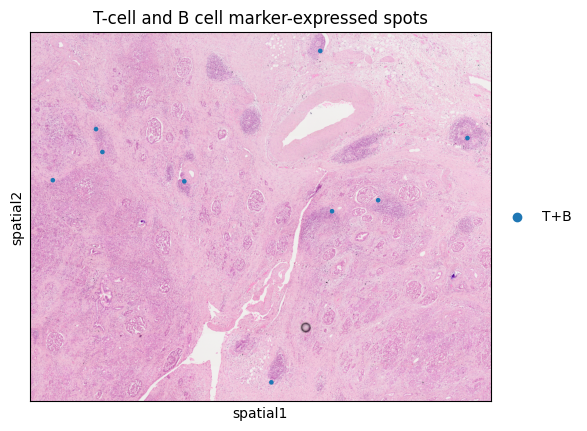

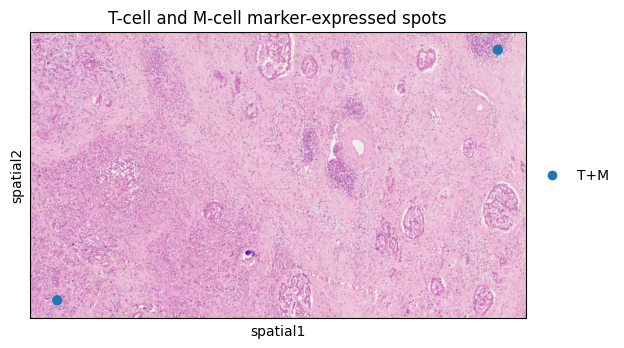

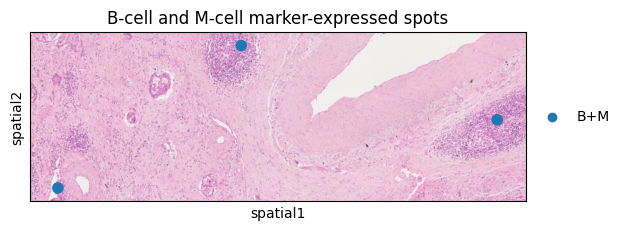

In [71]:
#Now generate a plot that overlays all the plots on 1 plot

def cytokine_marker_combos(spot):
    types = []
    if spot["TLS_t"]: types.append("T")
    if spot["TLS_b"]: types.append("B")
    if spot["TLS_m"]: types.append("M")
    if spot["Schwann_Markers"]: types.append("S")
    return "+".join(types) if types else "None"

adata_PA12.obs["TLS_markers"] = adata_PA12.obs.apply(cytokine_marker_combos, axis=1)
subset = adata_PA12[adata_PA12.obs["TLS_markers"] == "T+B"]
sc.pl.spatial(subset, color="TLS_markers", title="T-cell and B cell marker-expressed spots")
subset = adata_PA12[adata_PA12.obs["TLS_markers"] == "T+M"]
sc.pl.spatial(subset, color="TLS_markers", title="T-cell and M-cell marker-expressed spots")
subset = adata_PA12[adata_PA12.obs["TLS_markers"] == "B+M"]
sc.pl.spatial(subset, color="TLS_markers", title="B-cell and M-cell marker-expressed spots")
